In [54]:
import os
import pandas as pd
import numpy as np
import time
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from transformers import AutoTokenizer, AutoModelForSequenceClassification, FunnelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from sklearn.exceptions import UndefinedMetricWarning

import modules.deep_learning_modules as dl_modules

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [55]:
MODELTYPE = "bert_base" 
EPOCHS = 1
MAX_LEN = 512
BATCH_SIZE = 6
LEARNING_RATE = 0.001
DATASET = 'dataset_preprocessed_no_transformation' # dataset_preprocessed_no_transformation, dataset_preprocessed_stopwords
SEED_VAL = 42

base_path = '../datasets/01_preprocessed_datasets/' + DATASET + '.csv'

model_mapping = {   
                 
    "bert_base": "google-bert/bert-base-uncased",
    "distilbert":"distilbert/distilbert-base-uncased",
    "albert_base": "albert/albert-base-v2",
    "roberta": "openai-community/roberta-base-openai-detector",
    "transformer":"funnel-transformer/small-base",
}

## Test if GPU is available

In [56]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Use the GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## View Training/Validation Results

In [57]:
# Create a DataFrame from our training statistics.
df_stats = pd.read_csv(f"../performance_statistics/{MODELTYPE}/training_stats_{MODELTYPE}_{LEARNING_RATE}_{MAX_LEN}_{DATASET}.csv")
df_stats = df_stats.set_index('Epoch')
df_stats

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy,Training_Time,Validation_Time
Epoch,,,,,,
1,0.770788,0.504941,0.698610,0.449456,0:22:52,0:03:34
2,0.770824,0.504692,0.688029,0.550544,0:22:54,0:03:33
3,0.768220,0.507713,0.702246,0.550544,0:22:54,0:03:33
4,0.764482,0.506398,0.762143,0.550544,0:22:54,0:03:33
5,0.759885,0.505723,0.723827,0.550544,0:22:54,0:03:33
6,0.754572,0.508993,0.725789,0.550544,0:22:54,0:03:34
7,0.747766,0.510805,0.748078,0.550544,0:22:54,0:03:33
8,0.745242,0.510628,0.765444,0.550544,0:22:54,0:03:33
9,0.741767,0.511801,0.751141,0.550544,0:22:54,0:03:34


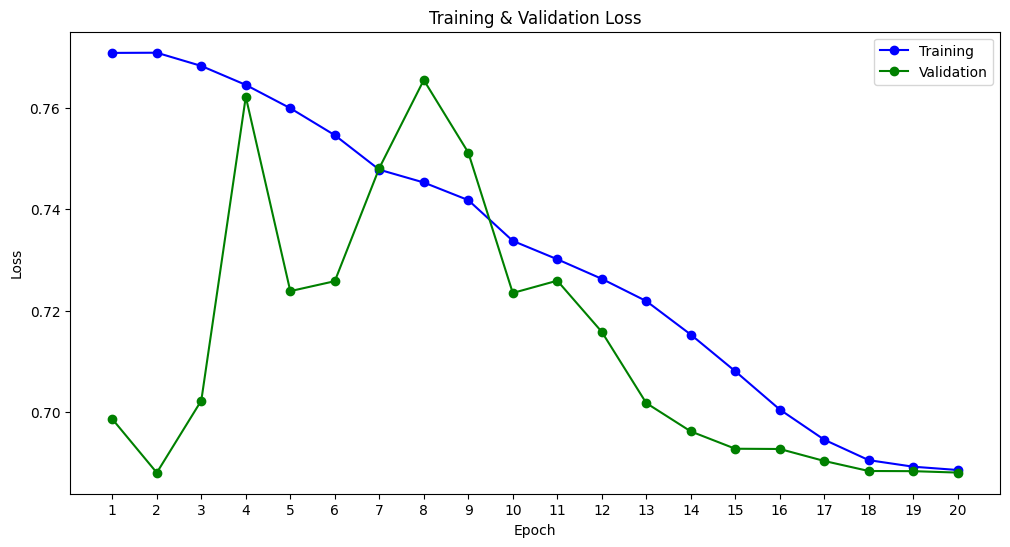

In [58]:
plt.figure(figsize=(12, 6))

# Plot the learning curve.
plt.plot(df_stats['Training_Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation_Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(df_stats.index)

plt.show()

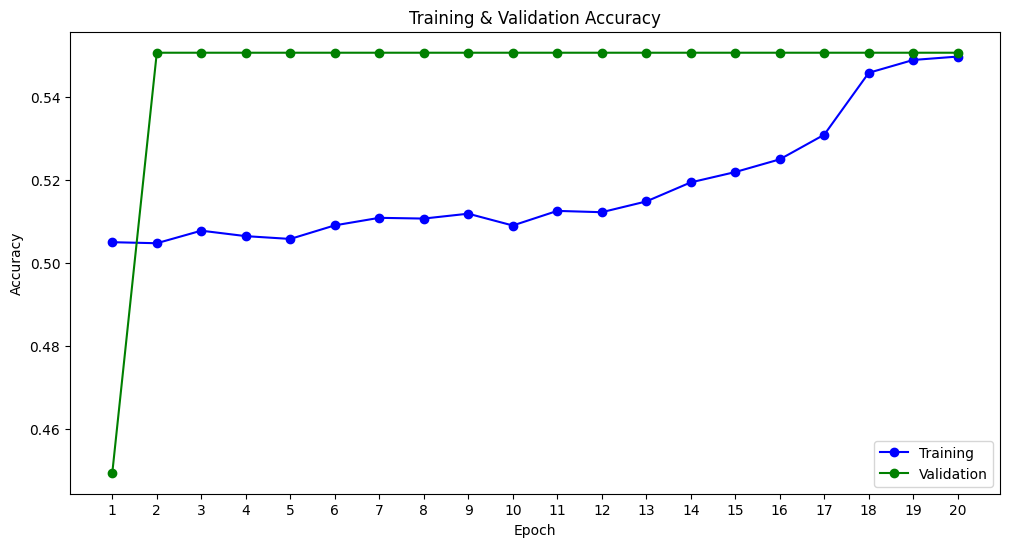

In [59]:
plt.figure(figsize=(12,6))

# Plot the learning curve.
plt.plot(df_stats['Training_Accuracy'], 'b-o', label="Training")
plt.plot(df_stats['Validation_Accuracy'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(df_stats.index)


plt.show()

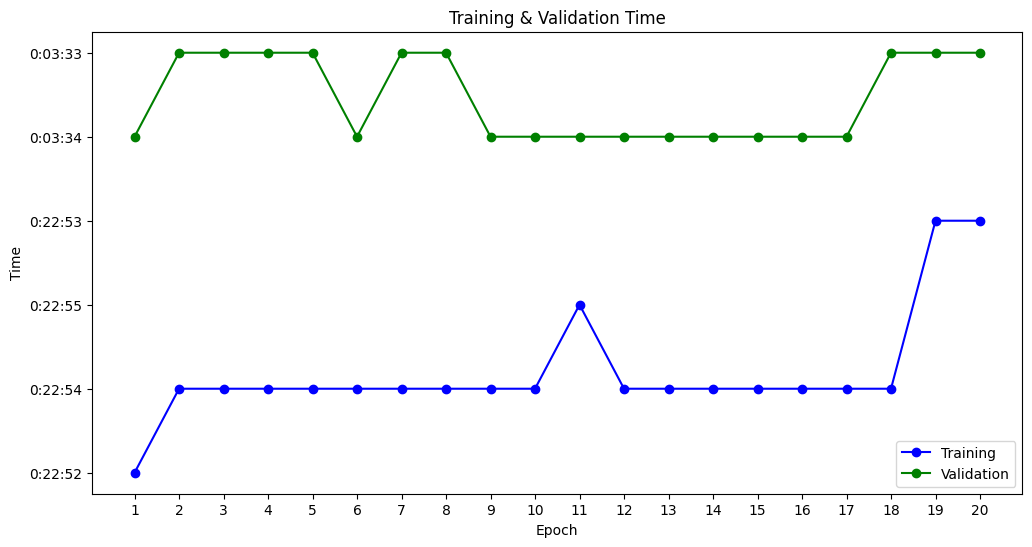

In [60]:
plt.figure(figsize=(12,6))

# Plot the learning curve.
plt.plot(df_stats['Training_Time'], 'b-o', label="Training")
plt.plot(df_stats['Validation_Time'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Time")
plt.xlabel("Epoch")
plt.ylabel("Time")
plt.legend()
plt.xticks(df_stats.index)


plt.show()

## Load Model

In [61]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = f'../models/{MODELTYPE}/'
folder_name = f"model_{MODELTYPE}_{LEARNING_RATE}_{MAX_LEN}_{DATASET}"

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
output_dir = output_dir + folder_name

In [62]:
model = AutoModelForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [63]:
# Load the test data
sentences, labels = dl_modules.read_data()
input_ids, attention_masks, labels = dl_modules.tokenize_data(sentences, labels, tokenizer, MAX_LEN)
_, _, test_dataset = dl_modules.create_data_split(input_ids, attention_masks, labels, SEED_VAL)
testing_dataloader = dl_modules.create_data_loader(test_dataset, BATCH_SIZE, False)

## Eval on Test Set

In [64]:
# Prediction on test set
print(f'Predicting labels for {len(test_dataset)} test sentences...')

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []
predictions_accuracy, true_labels_accuracy = [], []

# Predict 
for index, batch in enumerate(testing_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
    prediction_list = np.argmax(logits, axis=1).flatten()
    true_labels_list = label_ids.flatten()
    
    for i, prediction in enumerate(prediction_list):
        predictions_accuracy.append(prediction)
        true_labels_accuracy.append(true_labels_list[i])


    if index % 200 == 0 and index != 0:
    
      print(f"Done with {index} out of {len(testing_dataloader)} batches.")
  
print('DONE.')

Predicting labels for 9378 test sentences...
Done with 200 out of 1563 batches.
Done with 400 out of 1563 batches.
Done with 600 out of 1563 batches.
Done with 800 out of 1563 batches.
Done with 1000 out of 1563 batches.
Done with 1200 out of 1563 batches.
Done with 1400 out of 1563 batches.
DONE.


In [65]:
report = classification_report(predictions_accuracy, true_labels_accuracy, target_names=['not_hate', 'hate'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    not_hate       0.00      0.00      0.00         0
        hate       1.00      0.55      0.71      9378

    accuracy                           0.55      9378
   macro avg       0.50      0.27      0.35      9378
weighted avg       1.00      0.55      0.71      9378



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [66]:
# Extract the accuracy line
accuracy_line = report.split('\n')[5]  # Assuming consistent formatting

# Extract the accuracy value
accuracy_value = float(accuracy_line.split()[1])

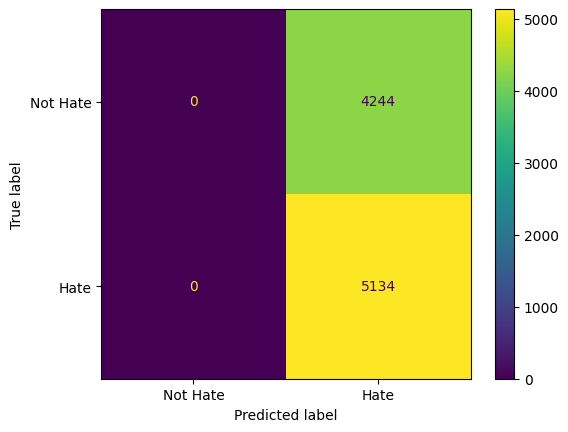

In [67]:
# Get Confusion Matrix
cm = confusion_matrix(true_labels_accuracy, predictions_accuracy)

# Print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= ['Not Hate', 'Hate'])

disp.plot()
plt.show()

## Matthews Correlation Coefficient

In [68]:
print(f'Positive hateful samples: {torch.sum(labels).item()} of {len(labels)} ({torch.sum(labels).item() / len(labels) * 100:.2f}%)')

Positive hateful samples: 25761 of 46890 (54.94%)


In [69]:
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


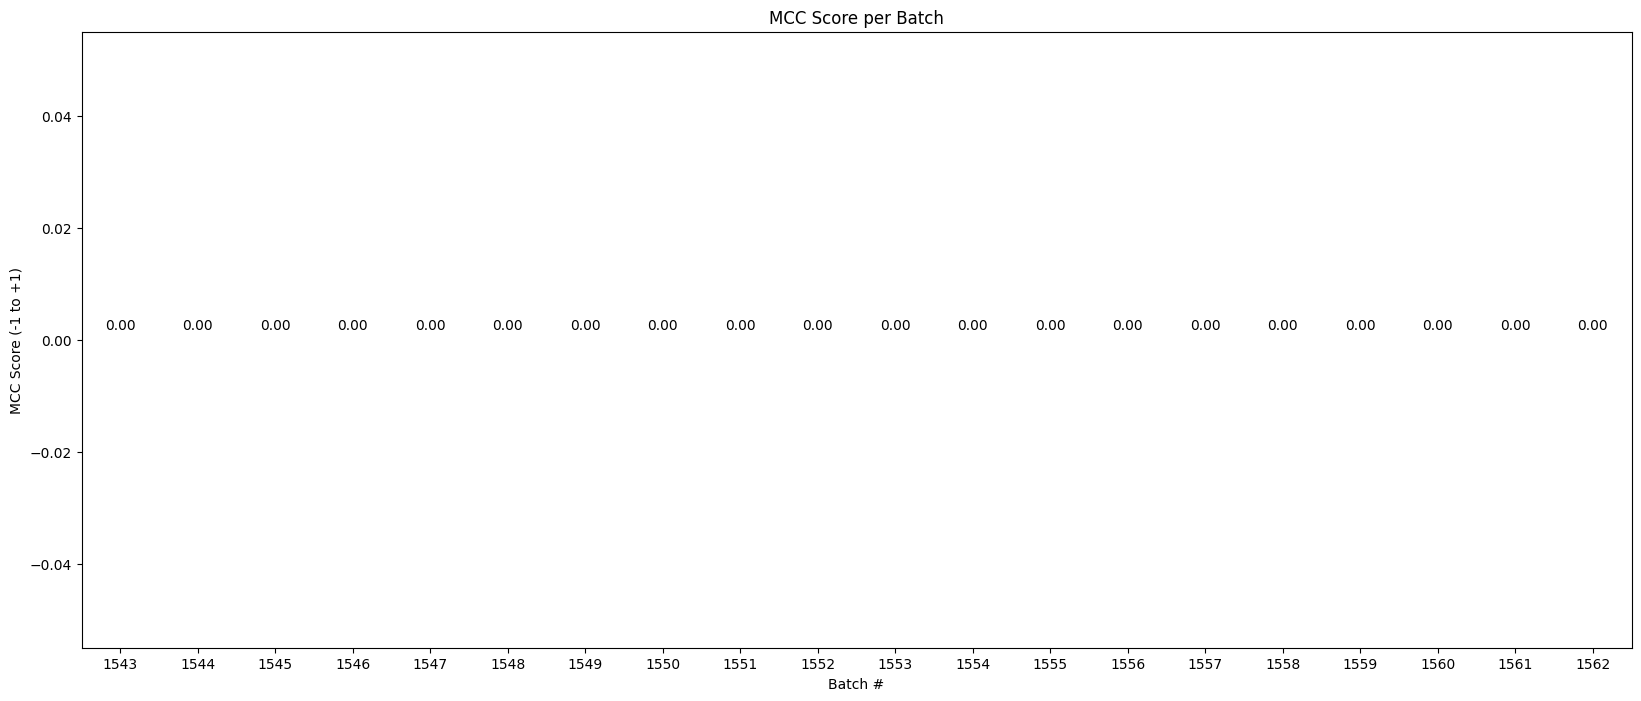

In [70]:
# Create a barplot showing the MCC score for each batch of test samples.
plt.figure(figsize=(20, 8))

ax = sns.barplot(x = list(range(len(matthews_set)- 20, len(matthews_set))), y = matthews_set[len(matthews_set) - 20: len(matthews_set)], errorbar=None)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [71]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print(f'Total MCC: {mcc:.3f}')

Total MCC: 0.000


## Save to Dataframe

In [72]:
if not os.path.exists("./overall_statistics.csv"):
    
    overall_statistics = pd.DataFrame(columns = ['Model', 'Accuracy', 'TN', 'FP', 'FN', 'TP', 'MCC'])
    overall_statistics.to_csv("./overall_statistics.csv", index=False)
    
overall_statistics = pd.read_csv("./overall_statistics.csv")

# create new dataframe
new_row = {'Model': folder_name, 'Accuracy': accuracy_value, 'TN': cm[0][0], 'FP': cm[0][1], 'FN': cm[1][0], 'TP': cm[1][1], 'MCC': mcc}

overall_statistics = pd.concat([overall_statistics, pd.DataFrame([new_row])], ignore_index=True)
overall_statistics.to_csv("./overall_statistics.csv", index=False)